In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scanpy as sc
from tqdm import tqdm
import seaborn as sns
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
import scipy.stats as stats
import statsmodels.stats.multicomp as mc
from scipy.stats import normaltest
from scipy.stats import shapiro
import scikit_posthocs as sp
import statsmodels.api as sm
from statsmodels.formula.api import ols
import math
import os

# CMA aging Atlas: Pancreas
Data downloaded from [Tabula muris senis](https://cellxgene.cziscience.com/collections/0b9d8a04-bb9d-44da-aa27-705bb65b54eb) project. Pancreas data, Smart-seq2 assay in .h5ad format was used for further analysis.

In [2]:
# Creating folder for outputs
os.makedirs('../Khwaja_et_al_outputs/Pancreas')

## Importing and preprocessing data

In [2]:
# Import h5ad file in scanpy. 
adata = sc.read_h5ad('../Exp. 2_Tabula muris/Files/TM_pancreas_smartseq.h5ad')

# Normalize as CPM (counts per million)
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e6)

# Transforming CPM into log form
sc.pp.log1p(adata)

## CMA score calculation

In [3]:
# Load matrix file with weight and direction 
model_matrix = pd.read_excel('../Exp. 2_Tabula muris/activation_model.xlsx')

# Removing EEF1A1 and RAC1 genes because they don't appear in the adata
model_matrix = model_matrix.drop([6, 8], axis=0).reset_index()

# Finding CMA network genes in the dataset
cma_network = adata[:, model_matrix["Ensembl_ms"]]

# Calculating the Zs scores
cma_data_zs = cma_network.copy().X.todense().T

for i in tqdm(np.arange(cma_data_zs.shape[0])):
    
    µ = np.mean(cma_data_zs[i, :])
    sd = np.std(cma_data_zs[i, :])
    
    cma_data_zs[i, :] = (cma_data_zs[i, :] - µ)/sd
    
# Generating a copy of adata.obs to work with
barcode = adata.obs.copy()

# New column in barcode (aka adata.obs) with the CMA scores for each cell detected
for i,j in enumerate(barcode.index):
        
    cell_matrix = model_matrix.copy()

    for g in cell_matrix.index:

        cell_matrix.loc[g, 'gene_count'] = cma_data_zs[g, i]

    cell_matrix['gene_score'] = cell_matrix['gene_count'] * cell_matrix['Direction'] * cell_matrix['Weight']
    score = cell_matrix['gene_score'].sum()/np.sum(cell_matrix['Weight'])

    barcode.loc[j, 'score'] = score   
    

100%|████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 2661.78it/s]


In [4]:
barcode.head()

,FACS.selection,age,cell,free_annotation,method,mouse.id,subtissue,n_genes,n_counts,louvain,...,organism_ontology_term_id,cell_type,assay,disease,organism,sex,tissue,ethnicity,development_stage,score
index,,,,,,,,,,,,,,,,,,,,,
A10_B000756_B007446_S10.mm10-plus-0-0,Viable,18m,A10_B000756,pancreatic B cell,facs,18_45_M,Endocrine,3212,6392.144043,1,...,NCBITaxon:10090,type B pancreatic cell,Smart-seq2,normal,Mus musculus,male,pancreas,na,18 month-old stage,-0.088692
A11_B000756_B007446_S11.mm10-plus-0-0,Viable,18m,A11_B000756,pancreatic B cell,facs,18_45_M,Endocrine,2544,5565.440918,1,...,NCBITaxon:10090,type B pancreatic cell,Smart-seq2,normal,Mus musculus,male,pancreas,na,18 month-old stage,-0.003498
A12_B000756_B007446_S12.mm10-plus-0-0,Viable,18m,A12_B000756,nan,facs,18_45_M,Endocrine,3789,4216.151367,3,...,NCBITaxon:10090,type B pancreatic cell,Smart-seq2,normal,Mus musculus,male,pancreas,na,18 month-old stage,0.180847
A13_B000756_B007446_S13.mm10-plus-0-0,Viable,18m,A13_B000756,nan,facs,18_45_M,Endocrine,4745,4410.768555,0,...,NCBITaxon:10090,type B pancreatic cell,Smart-seq2,normal,Mus musculus,male,pancreas,na,18 month-old stage,0.034758
A13_B002832_B007443_S13.mm10-plus-0-0,Viable,18m,A13_B002832,pancreatic acinar cell,facs,18_47_F,Exocrine,1050,813.061707,5,...,NCBITaxon:10090,pancreatic acinar cell,Smart-seq2,normal,Mus musculus,female,pancreas,na,18 month-old stage,-0.714637


## CMA net score/cell type (fold over whole tissue)

In [5]:
# Checking n of mice for Liver
list(barcode['mouse.id'].unique())

['18_45_M',
 '18_47_F',
 '24_60_M',
 '24_61_M',
 '3_8_M',
 '3_10_M',
 '3_39_F',
 '3_38_F']

**Mice n for Liver**
    - Young females: 2
    - Young males: 2
    - Old females: 1
    - Old males: 3

In [5]:
# Generating new ages
for j in barcode.index:    
    if barcode.loc[j, 'age'] == '3m':        
        barcode.loc[j, 'new_age'] = '3m'

    elif barcode.loc[j, 'age'] == '18m':                
        barcode.loc[j, 'new_age'] = '18-24m'

    elif barcode.loc[j, 'age'] == '24m': 
        barcode.loc[j, 'new_age'] = '18-24m'
barcode.head()

,FACS.selection,age,cell,free_annotation,method,mouse.id,subtissue,n_genes,n_counts,louvain,...,cell_type,assay,disease,organism,sex,tissue,ethnicity,development_stage,score,new_age
index,,,,,,,,,,,,,,,,,,,,,
A10_B000756_B007446_S10.mm10-plus-0-0,Viable,18m,A10_B000756,pancreatic B cell,facs,18_45_M,Endocrine,3212,6392.144043,1,...,type B pancreatic cell,Smart-seq2,normal,Mus musculus,male,pancreas,na,18 month-old stage,-0.088692,18-24m
A11_B000756_B007446_S11.mm10-plus-0-0,Viable,18m,A11_B000756,pancreatic B cell,facs,18_45_M,Endocrine,2544,5565.440918,1,...,type B pancreatic cell,Smart-seq2,normal,Mus musculus,male,pancreas,na,18 month-old stage,-0.003498,18-24m
A12_B000756_B007446_S12.mm10-plus-0-0,Viable,18m,A12_B000756,nan,facs,18_45_M,Endocrine,3789,4216.151367,3,...,type B pancreatic cell,Smart-seq2,normal,Mus musculus,male,pancreas,na,18 month-old stage,0.180847,18-24m
A13_B000756_B007446_S13.mm10-plus-0-0,Viable,18m,A13_B000756,nan,facs,18_45_M,Endocrine,4745,4410.768555,0,...,type B pancreatic cell,Smart-seq2,normal,Mus musculus,male,pancreas,na,18 month-old stage,0.034758,18-24m
A13_B002832_B007443_S13.mm10-plus-0-0,Viable,18m,A13_B002832,pancreatic acinar cell,facs,18_47_F,Exocrine,1050,813.061707,5,...,pancreatic acinar cell,Smart-seq2,normal,Mus musculus,female,pancreas,na,18 month-old stage,-0.714637,18-24m


In [6]:
# Calculation of net score to 3m using whole tissue CMA score mean
µ = np.mean(barcode[barcode['new_age'] == '3m']['score'])

for i in barcode.index:
    barcode.loc[i, 'net_score'] = barcode.loc[i, 'score'] - µ 

barcode.head()

,FACS.selection,age,cell,free_annotation,method,mouse.id,subtissue,n_genes,n_counts,louvain,...,assay,disease,organism,sex,tissue,ethnicity,development_stage,score,new_age,net_score
index,,,,,,,,,,,,,,,,,,,,,
A10_B000756_B007446_S10.mm10-plus-0-0,Viable,18m,A10_B000756,pancreatic B cell,facs,18_45_M,Endocrine,3212,6392.144043,1,...,Smart-seq2,normal,Mus musculus,male,pancreas,na,18 month-old stage,-0.088692,18-24m,-0.152319
A11_B000756_B007446_S11.mm10-plus-0-0,Viable,18m,A11_B000756,pancreatic B cell,facs,18_45_M,Endocrine,2544,5565.440918,1,...,Smart-seq2,normal,Mus musculus,male,pancreas,na,18 month-old stage,-0.003498,18-24m,-0.067126
A12_B000756_B007446_S12.mm10-plus-0-0,Viable,18m,A12_B000756,nan,facs,18_45_M,Endocrine,3789,4216.151367,3,...,Smart-seq2,normal,Mus musculus,male,pancreas,na,18 month-old stage,0.180847,18-24m,0.117219
A13_B000756_B007446_S13.mm10-plus-0-0,Viable,18m,A13_B000756,nan,facs,18_45_M,Endocrine,4745,4410.768555,0,...,Smart-seq2,normal,Mus musculus,male,pancreas,na,18 month-old stage,0.034758,18-24m,-0.028869
A13_B002832_B007443_S13.mm10-plus-0-0,Viable,18m,A13_B002832,pancreatic acinar cell,facs,18_47_F,Exocrine,1050,813.061707,5,...,Smart-seq2,normal,Mus musculus,female,pancreas,na,18 month-old stage,-0.714637,18-24m,-0.778264


In [8]:
barcode.cell_type.unique()

['type B pancreatic cell', 'pancreatic acinar cell', 'pancreatic A cell', 'pancreatic D cell', 'endothelial cell', 'leukocyte', 'pancreatic ductal cell', 'pancreatic stellate cell', 'pancreatic PP cell']
Categories (9, object): ['endothelial cell', 'leukocyte', 'pancreatic A cell', 'pancreatic D cell', ..., 'pancreatic acinar cell', 'pancreatic ductal cell', 'pancreatic stellate cell', 'type B pancreatic cell']

In [7]:
cells = ['pancreatic acinar cell', 'pancreatic A cell', 'type B pancreatic cell']

### Cell types stats

In [10]:
# Function for testing normality using D'Agostino-Pearson of different cell types and ages
def normalidad (df, tipo, años):
    long = []
    cell = []
    age = []
    estadistica=[]
    pval=[]
    result=[]   
    
    for x in tipo:
        for y in años:
            mydata = df[(df['cell_type']== x) & (df['new_age']== y)]
            n = len(mydata.index)
            data = list(mydata.net_score)            
            stat, p = normaltest(data)
            long.append(n)
            cell.append(x)
            age.append(y)
            estadistica.append(stat)
            pval.append(p)
            if p > 0.05:
                result.append("Normal")
            else:
                result.append("Not normal")    
    df_norm = pd.DataFrame({"Cell": cell, "Age": age, "n": long, "Stat":estadistica, "p value": pval, "Result":result})
    return(df_norm)

In [11]:
normalidad(barcode, tipo=cells, años=['3m', '18-24m'])

,Cell,Age,n,Stat,p value,Result
0,pancreatic acinar cell,3m,191,0.951544,0.621405,Normal
1,pancreatic acinar cell,18-24m,385,25.376327,0.000003,Not normal
2,pancreatic A cell,3m,364,0.452656,0.797456,Normal
3,pancreatic A cell,18-24m,157,4.138539,0.126278,Normal
4,type B pancreatic cell,3m,522,12.736666,0.001715,Not normal
5,type B pancreatic cell,18-24m,820,25.131072,0.000003,Not normal


In [13]:
# T test for normal populations
for i in ['pancreatic A cell']:
    # Levene
    group3 = list(barcode[barcode.cell_type==i][barcode.new_age=='3m']['net_score'])
    group18_24 = list(barcode[barcode.cell_type==i][barcode.new_age=='18-24m']['net_score'])
    print('{} stats'.format(i.title()))
    print("Length 3m: " + str(len(group3)))
    print("Length 18-24m: " + str(len(group18_24)))
    stat, p = stats.levene(group3, group18_24)
    print("Levene's test pval = " + str(p))

    stat2, p2 = stats.ttest_ind(group3, group18_24, equal_var=True)
    print("T test pval = " + str(p2))
    print('\n')

Pancreatic A Cell stats
Length 3m: 364
Length 18-24m: 157
Levene's test pval = 0.8229265982215044
T test pval = 0.009710925343666733




C:\Users\Adrian\AppData\Local\Temp\ipykernel_13392\3115745167.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  group3 = list(barcode[barcode.cell_type==i][barcode.new_age=='3m']['net_score'])
C:\Users\Adrian\AppData\Local\Temp\ipykernel_13392\3115745167.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  group18_24 = list(barcode[barcode.cell_type==i][barcode.new_age=='18-24m']['net_score'])


In [14]:
# Calculating MWU test (for not normal distributions) for the cells of interest
for i in [cells[0], cells[2]]:
    group3 = list(barcode[barcode.cell_type==i][barcode.new_age=='3m']['net_score'])
    group18_24 = list(barcode[barcode.cell_type==i][barcode.new_age=='18-24m']['net_score'])
    print('{} statistics'.format(i.title()))
    stat, p = stats.mannwhitneyu(group3, group18_24)
    print("MWU test pval = " + str(p))
    print('\n')

Pancreatic Acinar Cell statistics
MWU test pval = 0.029023662660032354


Type B Pancreatic Cell statistics
MWU test pval = 2.3018139249406245e-09




C:\Users\Adrian\AppData\Local\Temp\ipykernel_13392\2462003536.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  group3 = list(barcode[barcode.cell_type==i][barcode.new_age=='3m']['net_score'])
C:\Users\Adrian\AppData\Local\Temp\ipykernel_13392\2462003536.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  group18_24 = list(barcode[barcode.cell_type==i][barcode.new_age=='18-24m']['net_score'])


### Net score graph

C:\Users\Adrian\AppData\Local\Temp\ipykernel_13392\2335712598.py:57: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  y1=np.mean(barcode[barcode.cell_type==cells[0]][barcode.new_age=='18-24m']['net_score'])
C:\Users\Adrian\AppData\Local\Temp\ipykernel_13392\2335712598.py:58: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  y2=np.mean(barcode[barcode.cell_type==cells[1]][barcode.new_age=='18-24m']['net_score'])
C:\Users\Adrian\AppData\Local\Temp\ipykernel_13392\2335712598.py:59: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  y3=np.mean(barcode[barcode.cell_type==cells[2]][barcode.new_age=='18-24m']['net_score'])


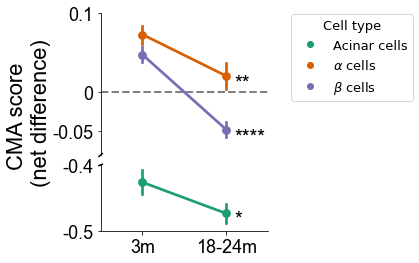

In [33]:
# Preparing the figure with broken Y ax
# Setting the grid
fig = plt.figure(figsize=(3,4))
gs = fig.add_gridspec(nrows=3, ncols=1, figure=fig, hspace=0.15)
hfont = {'fontname':'Arial'}

# Top ax
ax1 = fig.add_subplot(gs[0:2, 0]) # Bigger than the lower one
ax1 = sns.pointplot(x='new_age', y='net_score', data=barcode, hue='cell_type', order=["3m", "18-24m"],
                    hue_order=[cells[1], cells[2]], palette=['#d95f02', '#7570b3'], ci=68, ax=ax1)
ax1.legend([], [], frameon = False)
plt.axhline(y=0, linestyle='dashed', linewidth=2, color='gray', zorder=1)
plt.ylabel('')
ax1.xaxis.set_visible(False)
ax1.spines['bottom'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.set_xticklabels(["3m", "18-24m"], fontdict={'family':'Arial', 'size': 18})
plt.xlim(-0.5, 1.5)
plt.ylim(-0.08, 0.10) 
ax1.set_yticks([-0.05, 0, 0.10])
ax1.set_yticklabels([-0.05, 0, 0.10], fontdict={'family':'Arial', 'size': 18})

# Bottom ax
ax2 = fig.add_subplot(gs[2, 0])
ax2 = sns.pointplot(x='new_age', y='net_score', data=barcode, hue='cell_type', order=["3m", "18-24m"],
                    hue_order=['pancreatic acinar cell'], palette=["#1b9e77"], ci=68, ax=ax2)
ax2.legend([], [], frameon = False)
plt.ylabel('CMA score \n(net difference)', fontdict={'family':'Arial', 'size': 22}, y=1.8, labelpad=12)
ax2.set_xticklabels(["3m", "18-24m"], fontdict={'family':'Arial', 'size': 18})
plt.xlabel('')
ax2.spines['right'].set_visible(False)
plt.xlim(-0.5, 1.5)
plt.ylim(-0.5, -0.40) 
ax2.set_yticks([-0.50, -0.40])
ax2.set_yticklabels([-0.50, -0.40], fontdict={'family':'Arial', 'size': 18})
ax2.spines['top'].set_visible(False)

# Breaks
d = .01  # how big to make the diagonal lines in axes coordinates
# arguments to pass to plot, just so we don't keep repeating them
kwargs = dict(transform=ax1.transAxes, color="k", clip_on=False)
ax1.plot((-d, +d), (-d, +d), **kwargs)        # top-left diagonal
kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal

# Legend
legend_elements = [Line2D([], [], color='#1b9e77',marker='o', lw=0, label='Acinar cells'),
                   Line2D([0], [0], color='#d95f02', marker='o', lw=0, label=r'$\alpha$ cells'),
                   Line2D([0], [0], color='#7570b3', marker='o', lw=0, label=r'$\beta$ cells')]  

fig.legend(handles = legend_elements, bbox_to_anchor = (1.6, 0.9), title="Cell type", title_fontsize = 13, fontsize=13)


# Stats
x1= 1.1   
y1=np.mean(barcode[barcode.cell_type==cells[0]][barcode.new_age=='18-24m']['net_score'])
y2=np.mean(barcode[barcode.cell_type==cells[1]][barcode.new_age=='18-24m']['net_score'])
y3=np.mean(barcode[barcode.cell_type==cells[2]][barcode.new_age=='18-24m']['net_score'])

ax2.text(x1, y1-0.017, "*", fontsize=20, **hfont)
ax1.text(x1, y2-0.017, "**", fontsize=20, **hfont)
ax1.text(x1, y3-0.017, "****", fontsize=20, **hfont)

plt.savefig('../Khwaja_et_al_outputs/Pancreas/Panc_nscorrect.png',bbox_inches='tight', dpi=300)
                   
plt.show()

### Raw data

In [34]:
# Extracting raw values for pointplot graphic
long = []
celula = []
age = []
mean=[]
sem=[]

for x in cells:
    for y in ['3m', '18-24m']:
        n = len(barcode[barcode['cell_type']== x][barcode['new_age']== y].index)
        m = np.mean(barcode[barcode['cell_type']== x][barcode['new_age']== y]['net_score'])
        s = stats.sem(np.array(barcode[barcode['cell_type']== x][barcode['new_age']== y]['net_score']))
        
        long.append(n)
        celula.append(x)
        age.append(y)
        mean.append(m)
        sem.append(s)
        
df_raw = pd.DataFrame({"Cell_type": celula, "Age": age, "n": long, "Mean":mean, "SEM": sem})
df_raw

C:\Users\Adrian\AppData\Local\Temp\ipykernel_13392\3898692796.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  n = len(barcode[barcode['cell_type']== x][barcode['new_age']== y].index)
C:\Users\Adrian\AppData\Local\Temp\ipykernel_13392\3898692796.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  m = np.mean(barcode[barcode['cell_type']== x][barcode['new_age']== y]['net_score'])
C:\Users\Adrian\AppData\Local\Temp\ipykernel_13392\3898692796.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  s = stats.sem(np.array(barcode[barcode['cell_type']== x][barcode['new_age']== y]['net_score']))


,Cell_type,Age,n,Mean,SEM
0,pancreatic acinar cell,3m,191,-0.426358,0.018212
1,pancreatic acinar cell,18-24m,385,-0.473659,0.014664
2,pancreatic A cell,3m,364,0.073119,0.011155
3,pancreatic A cell,18-24m,157,0.020492,0.016859
4,type B pancreatic cell,3m,522,0.047513,0.009514
5,type B pancreatic cell,18-24m,820,-0.047659,0.009612


In [35]:
df_raw.to_excel('../Khwaja_et_al_outputs/Pancreas/Raw_data.xlsx', 'Netsc', index=False)

## CMA net score/cell type & sex (fold over whole tissue)

### Stats

In [8]:
# Calculating n of cells per cell type, sex and age
for i in cells:
    print(i.title() + " length:" + str(len(barcode[barcode["cell_type"]==i].index)))
    print(barcode[barcode["cell_type"]==i].value_counts(["sex", "new_age"]))
    print("\n")

Pancreatic Acinar Cell length:576
sex     new_age
male    18-24m     267
female  18-24m     118
        3m         100
male    3m          91
dtype: int64


Pancreatic A Cell length:521
sex     new_age
male    3m         183
female  3m         181
male    18-24m     116
female  18-24m      41
dtype: int64


Type B Pancreatic Cell length:1342
sex     new_age
male    18-24m     678
female  3m         281
male    3m         241
female  18-24m     142
dtype: int64




In [9]:
# 2-way Anova for all cells
for i in cells:
    intdf = barcode[barcode['cell_type']==i].reset_index()    
    
    # 2-way Anova
    model = ols('net_score ~ C(new_age) + C(sex) + C(new_age):C(sex)',data=intdf).fit()
    result = sm.stats.anova_lm(model, type=2)
    print(i.title()+' 2-way Anova\n')
    print(result)
    print('\n')
    
    # Post hocs multi comparissons Bonferroni
    interaction_groups = intdf.new_age.astype(str) + " & " + intdf.sex.astype(str)
    comp = mc.MultiComparison(intdf['net_score'], interaction_groups)
    tbl, a1, a2 = comp.allpairtest(stats.ttest_ind, method= "bonf")
    print(i.title()+' Post-Hoc Bonferroni\n')
    print(tbl)
    print('\n')

Pancreatic Acinar Cell 2-way Anova

                      df     sum_sq   mean_sq         F    PR(>F)
C(new_age)           1.0   0.285639  0.285639  3.736276  0.053736
C(sex)               1.0   0.087071  0.087071  1.138928  0.286329
C(new_age):C(sex)    1.0   0.008810  0.008810  0.115242  0.734378
Residual           572.0  43.729454  0.076450       NaN       NaN


Pancreatic Acinar Cell Post-Hoc Bonferroni

Test Multiple Comparison ttest_ind 
FWER=0.05 method=bonf
alphacSidak=0.01, alphacBonf=0.008
     group1         group2      stat   pval  pval_corr reject
-------------------------------------------------------------
18-24m & female 18-24m & male -0.6169 0.5376       1.0  False
18-24m & female   3m & female -1.0979 0.2735       1.0  False
18-24m & female     3m & male -1.9829 0.0487    0.2922  False
  18-24m & male   3m & female -0.7548 0.4509       1.0  False
  18-24m & male     3m & male -1.8648  0.063    0.3782  False
    3m & female     3m & male -1.0077 0.3149       1.0  False

### Graphs

#### Acinar cells

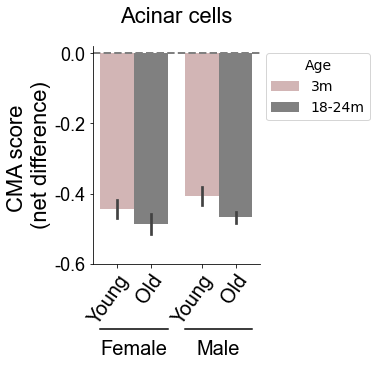

In [14]:
fig, ax = plt.subplots(figsize=(3,4))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
hfont = {'fontname':'Arial'}

sns.barplot(x='sex', y='net_score', data=barcode[barcode.cell_type==cells[0]], 
            hue='new_age', order=["female", "male"], hue_order=['3m', "18-24m"], palette=['#D7B0B0', '#808080'], ci=68)

plt.axhline(y=0, linestyle='dashed', linewidth=2, color='gray', zorder=1)
plt.xlabel('')
plt.ylabel('CMA score \n(net difference)', fontdict={'family':'Arial', 'size': 22})
ax.set_xticks([-0.2, 0.2, 0.8, 1.2])
ax.set_xticklabels(["Young", "Old", "Young", "Old"], fontdict={'family':'Arial', 'size': 20}, 
                   rotation=55, ha='right', rotation_mode='anchor')
plt.ylim(-0.60, 0.02)
ax.set_yticks([-0.60, -0.40, -0.20, 0.0])
ax.set_yticklabels([-0.60, -0.40, -0.20, 0.0], fontdict={'family':'Arial', 'size': 18})
h, l = ax.get_legend_handles_labels()
ax.legend(h, ['3m', "18-24m"], bbox_to_anchor=(1.7, 1), title="Age", title_fontsize = "14", fontsize = 14)
plt.title(label='Acinar cells', fontdict={'family':'Arial', 'size': 22}, y=1.08) 

# Female & male
trans = ax.get_xaxis_transform()
ax.annotate('Female', xy=(0, -.35), xycoords=trans, ha="center", va="top", size=20, **hfont)
ax.plot([-.4,0.4],[-.3,-.3], color="k", transform=trans, clip_on=False)
ax.annotate('Male', xy=(1, -.35), xycoords=trans, ha="center", va="top", size=20, **hfont)
ax.plot([0.6,1.4],[-.3,-.3], color="k", transform=trans, clip_on=False)

plt.savefig('../Khwaja_et_al_outputs/Pancreas/Acin_ns_sex.png',bbox_inches='tight', dpi=300)

plt.show()

#### Alpha cells

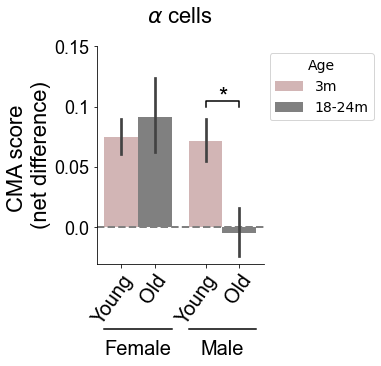

In [27]:
fig, ax = plt.subplots(figsize=(3,4))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
hfont = {'fontname':'Arial'}

sns.barplot(x='sex', y='net_score', data=barcode[barcode.cell_type==cells[1]], 
            hue='new_age', order=["female", "male"], hue_order=['3m', "18-24m"], palette=['#D7B0B0', '#808080'], ci=68)

plt.axhline(y=0, linestyle='dashed', linewidth=2, color='gray', zorder=1)
plt.xlabel('')
plt.ylabel('CMA score \n(net difference)', fontdict={'family':'Arial', 'size': 22})
ax.set_xticks([-0.2, 0.2, 0.8, 1.2])
ax.set_xticklabels(["Young", "Old", "Young", "Old"], fontdict={'family':'Arial', 'size': 20}, 
                   rotation=55, ha='right', rotation_mode='anchor')
plt.ylim(-0.03, 0.15)
ax.set_yticks([0.0, 0.05, 0.10, 0.15])
ax.set_yticklabels([0.0, 0.05, 0.10, 0.15], fontdict={'family':'Arial', 'size': 18})
h, l = ax.get_legend_handles_labels()
ax.legend(h, ['3m', "18-24m"], bbox_to_anchor=(1.7, 1), title="Age", title_fontsize = "14", fontsize = 14)
plt.title(label=r'$\alpha$ cells', fontdict={'family':'Arial', 'size': 22}, y=1.08)

# statistical annotation
x1, x2 = 0.8, 1.2   
y, h, col = 0.10 , 0.005, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y-0.002, "*", ha='center', va='bottom', color=col, fontdict={'family':'Arial', 'size': 24})

# Female & male
trans = ax.get_xaxis_transform()
ax.annotate('Female', xy=(0, -.35), xycoords=trans, ha="center", va="top", size=20, **hfont)
ax.plot([-.4,0.4],[-.3,-.3], color="k", transform=trans, clip_on=False)
ax.annotate('Male', xy=(1, -.35), xycoords=trans, ha="center", va="top", size=20, **hfont)
ax.plot([0.6,1.4],[-.3,-.3], color="k", transform=trans, clip_on=False)

plt.savefig('../Khwaja_et_al_outputs/Pancreas/A_ns_sex.png',bbox_inches='tight', dpi=300)

plt.show()

#### Beta cells

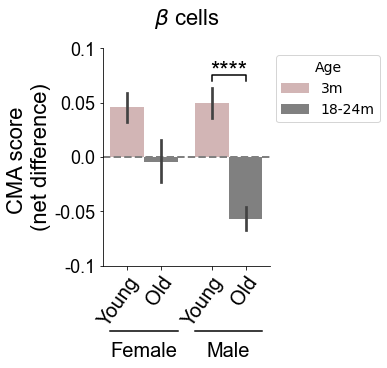

In [35]:
fig, ax = plt.subplots(figsize=(3,4))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
hfont = {'fontname':'Arial'}

sns.barplot(x='sex', y='net_score', data=barcode[barcode.cell_type==cells[2]], 
            hue='new_age', order=["female", "male"], hue_order=['3m', "18-24m"], palette=['#D7B0B0', '#808080'], ci=68)

plt.axhline(y=0, linestyle='dashed', linewidth=2, color='gray', zorder=1)
plt.xlabel('')
plt.ylabel('CMA score \n(net difference)', fontdict={'family':'Arial', 'size': 22})
ax.set_xticks([-0.2, 0.2, 0.8, 1.2])
ax.set_xticklabels(["Young", "Old", "Young", "Old"], fontdict={'family':'Arial', 'size': 20}, 
                   rotation=55, ha='right', rotation_mode='anchor')
plt.ylim(-0.10, 0.10)
ax.set_yticks([-0.10, -0.05, 0.0, 0.05, 0.10])
ax.set_yticklabels([-0.10, -0.05, 0.0, 0.05, 0.10], fontdict={'family':'Arial', 'size': 18})
h, l = ax.get_legend_handles_labels()
ax.legend(h, ['3m', "18-24m"], bbox_to_anchor=(1.7, 1), title="Age", title_fontsize = "14", fontsize = 14)
plt.title(label=r'$\beta$ cells', fontdict={'family':'Arial', 'size': 22}, y=1.08)

# statistical annotation
x1, x2 = 0.8, 1.2   
y, h, col = 0.07 , 0.005, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y-0.002, "****", ha='center', va='bottom', color=col, fontdict={'family':'Arial', 'size': 24})

# Female & male
trans = ax.get_xaxis_transform()
ax.annotate('Female', xy=(0, -.35), xycoords=trans, ha="center", va="top", size=20, **hfont)
ax.plot([-.4,0.4],[-.3,-.3], color="k", transform=trans, clip_on=False)
ax.annotate('Male', xy=(1, -.35), xycoords=trans, ha="center", va="top", size=20, **hfont)
ax.plot([0.6,1.4],[-.3,-.3], color="k", transform=trans, clip_on=False)

plt.savefig('../Khwaja_et_al_outputs/Pancreas/B_ns_sex.png',bbox_inches='tight', dpi=300)

plt.show()

### Raw data

In [38]:
# Extracting raw values for bar graphs graphic
def raw (tipos, edad, sex):
    long = []
    celula = []
    age = []
    mean=[]
    sem=[]
    sexo = []

    for i in tipos:
        for x in edad:
            for y in sex:
                n = len(barcode[barcode['cell_type']== i][barcode['new_age']== x][barcode['sex']== y].index)
                m = np.mean(barcode[barcode['cell_type']== i][barcode['new_age']== x][barcode['sex']== y]['net_score'])
                s = stats.sem(barcode[barcode['cell_type']== i][barcode['new_age']== x][barcode['sex']== y]['net_score'])

                long.append(n)
                celula.append(i)                
                age.append(x)
                sexo.append(y)
                mean.append(m)
                sem.append(s)

    df_raw = pd.DataFrame({"Cell_type": celula, "Age": age, "Sex":sexo, "n": long, "Mean":mean, "SEM": sem})
    with pd.ExcelWriter("../Khwaja_et_al_outputs/Pancreas/Raw_data.xlsx", mode="a", if_sheet_exists='replace', 
                        engine="openpyxl") as writer:
        df_raw.to_excel(writer, sheet_name="Nsbysex", index=False)
    return(df_raw)

In [39]:
raw(tipos = cells, edad=['3m', '18-24m'], sex=['female', 'male'])

C:\Users\Adrian\AppData\Local\Temp\ipykernel_16428\64110958.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  n = len(barcode[barcode['cell_type']== i][barcode['new_age']== x][barcode['sex']== y].index)
C:\Users\Adrian\AppData\Local\Temp\ipykernel_16428\64110958.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  m = np.mean(barcode[barcode['cell_type']== i][barcode['new_age']== x][barcode['sex']== y]['net_score'])
C:\Users\Adrian\AppData\Local\Temp\ipykernel_16428\64110958.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  s = stats.sem(barcode[barcode['cell_type']== i][barcode['new_age']== x][barcode['sex']== y]['net_score'])


,Cell_type,Age,Sex,n,Mean,SEM
0,pancreatic acinar cell,3m,female,100,-0.443864,0.025501
1,pancreatic acinar cell,3m,male,91,-0.407121,0.025995
2,pancreatic acinar cell,18-24m,female,118,-0.487279,0.029291
3,pancreatic acinar cell,18-24m,male,267,-0.467641,0.016744
4,pancreatic A cell,3m,female,181,0.074580,0.013875
5,pancreatic A cell,3m,male,183,0.071673,0.017474
6,pancreatic A cell,18-24m,female,41,0.091496,0.031274
7,pancreatic A cell,18-24m,male,116,-0.004604,0.019509
8,type B pancreatic cell,3m,female,281,0.046063,0.012920
9,type B pancreatic cell,3m,male,241,0.049203,0.014090


## CMA net score/cell type & sex (fold over each cell type young)

In [40]:
# Calculation of net score (fold to 3m for each individual cell type)
for maj_cell in tqdm(np.unique(barcode['cell_type'])):
    
    µ = np.mean(barcode[barcode['cell_type'] == maj_cell][barcode['new_age'] == '3m']['score'])
    
    for cell_index in barcode[barcode['cell_type'] == maj_cell].index:
    
        barcode.loc[cell_index, 'celltype_ns'] = barcode.loc[cell_index, 'score'] - µ  

barcode.head()

  0%|                                                                                            | 0/9 [00:00<?, ?it/s]C:\Users\Adrian\AppData\Local\Temp\ipykernel_16428\2073192913.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  µ = np.mean(barcode[barcode['cell_type'] == maj_cell][barcode['new_age'] == '3m']['score'])
C:\Users\Adrian\AppData\Local\Temp\ipykernel_16428\2073192913.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  µ = np.mean(barcode[barcode['cell_type'] == maj_cell][barcode['new_age'] == '3m']['score'])
100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 12.19it/s]


,FACS.selection,age,cell,free_annotation,method,mouse.id,subtissue,n_genes,n_counts,louvain,...,disease,organism,sex,tissue,ethnicity,development_stage,score,new_age,net_score,celltype_ns
index,,,,,,,,,,,,,,,,,,,,,
A10_B000756_B007446_S10.mm10-plus-0-0,Viable,18m,A10_B000756,pancreatic B cell,facs,18_45_M,Endocrine,3212,6392.144043,1,...,normal,Mus musculus,male,pancreas,na,18 month-old stage,-0.088692,18-24m,-0.152319,-0.199832
A11_B000756_B007446_S11.mm10-plus-0-0,Viable,18m,A11_B000756,pancreatic B cell,facs,18_45_M,Endocrine,2544,5565.440918,1,...,normal,Mus musculus,male,pancreas,na,18 month-old stage,-0.003498,18-24m,-0.067126,-0.114639
A12_B000756_B007446_S12.mm10-plus-0-0,Viable,18m,A12_B000756,nan,facs,18_45_M,Endocrine,3789,4216.151367,3,...,normal,Mus musculus,male,pancreas,na,18 month-old stage,0.180847,18-24m,0.117219,0.069706
A13_B000756_B007446_S13.mm10-plus-0-0,Viable,18m,A13_B000756,nan,facs,18_45_M,Endocrine,4745,4410.768555,0,...,normal,Mus musculus,male,pancreas,na,18 month-old stage,0.034758,18-24m,-0.028869,-0.076382
A13_B002832_B007443_S13.mm10-plus-0-0,Viable,18m,A13_B002832,pancreatic acinar cell,facs,18_47_F,Exocrine,1050,813.061707,5,...,normal,Mus musculus,female,pancreas,na,18 month-old stage,-0.714637,18-24m,-0.778264,-0.351906


### Graphs

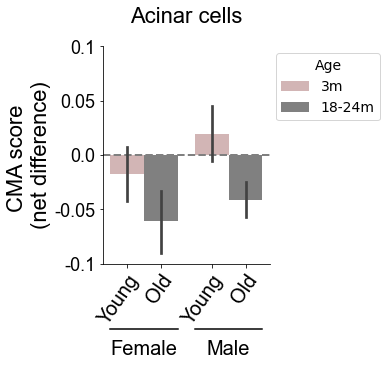

In [42]:
# Figure Acinar
fig, ax = plt.subplots(figsize=(3,4))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
hfont = {'fontname':'Arial'}

sns.barplot(x='sex', y='celltype_ns', data=barcode[barcode.cell_type==cells[0]], 
            hue='new_age', order=["female", "male"], hue_order=['3m', "18-24m"], palette=['#D7B0B0', '#808080'], ci=68)

plt.axhline(y=0, linestyle='dashed', linewidth=2, color='gray', zorder=1)
plt.xlabel('')
plt.ylabel('CMA score \n(net difference)', fontdict={'family':'Arial', 'size': 22})
ax.set_xticks([-0.2, 0.2, 0.8, 1.2])
ax.set_xticklabels(["Young", "Old", "Young", "Old"], fontdict={'family':'Arial', 'size': 20}, 
                   rotation=55, ha='right', rotation_mode='anchor')
plt.ylim(-0.10, 0.10)
ax.set_yticks([-0.10, -0.05, 0.00, 0.05, 0.10])
ax.set_yticklabels([-0.10, -0.05, 0.00, 0.05, 0.10], fontdict={'family':'Arial', 'size': 18})
h, l = ax.get_legend_handles_labels()
ax.legend(h, ['3m', "18-24m"], bbox_to_anchor=(1.7, 1), title="Age", title_fontsize = "14", fontsize = 14)
plt.title(label='Acinar cells', fontdict={'family':'Arial', 'size': 22}, y=1.08)
 
# Female & male
trans = ax.get_xaxis_transform()
ax.annotate('Female', xy=(0, -.35), xycoords=trans, ha="center", va="top", size=20, **hfont)
ax.plot([-.4,0.4],[-.3,-.3], color="k", transform=trans, clip_on=False)
ax.annotate('Male', xy=(1, -.35), xycoords=trans, ha="center", va="top", size=20, **hfont)
ax.plot([0.6,1.4],[-.3,-.3], color="k", transform=trans, clip_on=False)

plt.savefig('../Khwaja_et_al_outputs/Pancreas/Acin_cellns_sex.png',bbox_inches='tight', dpi=300)

plt.show()

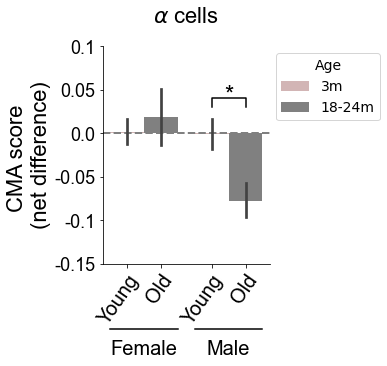

In [44]:
# Figure Alpha cells
fig, ax = plt.subplots(figsize=(3,4))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
hfont = {'fontname':'Arial'}

sns.barplot(x='sex', y='celltype_ns', data=barcode[barcode.cell_type==cells[1]], 
            hue='new_age', order=["female", "male"], hue_order=['3m', "18-24m"], palette=['#D7B0B0', '#808080'], ci=68)

plt.axhline(y=0, linestyle='dashed', linewidth=2, color='gray', zorder=1)
plt.xlabel('')
plt.ylabel('CMA score \n(net difference)', fontdict={'family':'Arial', 'size': 22})
ax.set_xticks([-0.2, 0.2, 0.8, 1.2])
ax.set_xticklabels(["Young", "Old", "Young", "Old"], fontdict={'family':'Arial', 'size': 20}, 
                   rotation=55, ha='right', rotation_mode='anchor')
plt.ylim(-0.15, 0.10)
ax.set_yticks([-0.15, -0.10, -0.05, 0.00, 0.05, 0.10])
ax.set_yticklabels([-0.15, -0.10, -0.05, 0.00, 0.05, 0.10], fontdict={'family':'Arial', 'size': 18})
h, l = ax.get_legend_handles_labels()
ax.legend(h, ['3m', "18-24m"], bbox_to_anchor=(1.7, 1), title="Age", title_fontsize = "14", fontsize = 14)
plt.title(label=r'$\alpha$ cells', fontdict={'family':'Arial', 'size': 22}, y=1.08)
 

# statistical annotation
x1, x2 = 0.8, 1.2   
y, h, col = 0.03 , 0.01, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y, "*", ha='center', va='bottom', color=col, fontdict={'family':'Arial', 'size': 24})

# Female & male
trans = ax.get_xaxis_transform()
ax.annotate('Female', xy=(0, -.35), xycoords=trans, ha="center", va="top", size=20, **hfont)
ax.plot([-.4,0.4],[-.3,-.3], color="k", transform=trans, clip_on=False)
ax.annotate('Male', xy=(1, -.35), xycoords=trans, ha="center", va="top", size=20, **hfont)
ax.plot([0.6,1.4],[-.3,-.3], color="k", transform=trans, clip_on=False)

plt.savefig('../Khwaja_et_al_outputs/Pancreas/A_cellns_sex.png',bbox_inches='tight', dpi=300)

plt.show()

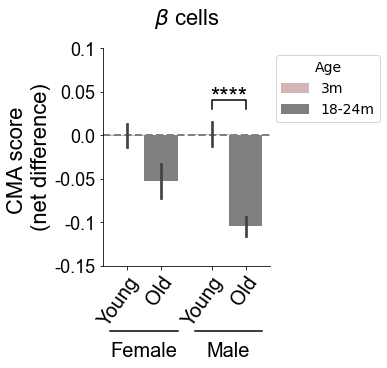

In [46]:
# Figure Beta cells
fig, ax = plt.subplots(figsize=(3,4))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
hfont = {'fontname':'Arial'}

sns.barplot(x='sex', y='celltype_ns', data=barcode[barcode.cell_type==cells[2]], 
            hue='new_age', order=["female", "male"], hue_order=['3m', "18-24m"], palette=['#D7B0B0', '#808080'], ci=68)

plt.axhline(y=0, linestyle='dashed', linewidth=2, color='gray', zorder=1)
plt.xlabel('')
plt.ylabel('CMA score \n(net difference)', fontdict={'family':'Arial', 'size': 22})
ax.set_xticks([-0.2, 0.2, 0.8, 1.2])
ax.set_xticklabels(["Young", "Old", "Young", "Old"], fontdict={'family':'Arial', 'size': 20}, 
                   rotation=55, ha='right', rotation_mode='anchor')
plt.ylim(-0.15, 0.10)
ax.set_yticks([-0.15, -0.10, -0.05, 0.00, 0.05, 0.10])
ax.set_yticklabels([-0.15, -0.10, -0.05, 0.00, 0.05, 0.10], fontdict={'family':'Arial', 'size': 18})
h, l = ax.get_legend_handles_labels()
ax.legend(h, ['3m', "18-24m"], bbox_to_anchor=(1.7, 1), title="Age", title_fontsize = "14", fontsize = 14)
plt.title(label=r'$\beta$ cells', fontdict={'family':'Arial', 'size': 22}, y=1.08)
 

# statistical annotation
x1, x2 = 0.8, 1.2   
y, h, col = 0.03 , 0.01, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y, "****", ha='center', va='bottom', color=col, fontdict={'family':'Arial', 'size': 24})

# Female & male
trans = ax.get_xaxis_transform()
ax.annotate('Female', xy=(0, -.35), xycoords=trans, ha="center", va="top", size=20, **hfont)
ax.plot([-.4,0.4],[-.3,-.3], color="k", transform=trans, clip_on=False)
ax.annotate('Male', xy=(1, -.35), xycoords=trans, ha="center", va="top", size=20, **hfont)
ax.plot([0.6,1.4],[-.3,-.3], color="k", transform=trans, clip_on=False)

plt.savefig('../Khwaja_et_al_outputs/Pancreas/B_cellns_sex.png',bbox_inches='tight', dpi=300)

plt.show()

### Raw data

In [48]:
# Extracting raw values for bar graphs graphic
def raw (tipos, edad, sex):
    long = []
    celula = []
    age = []
    mean=[]
    sem=[]
    sexo = []

    for i in tipos:
        for x in edad:
            for y in sex:
                n = len(barcode[barcode['cell_type']== i][barcode['new_age']== x][barcode['sex']== y].index)
                m = np.mean(barcode[barcode['cell_type']== i][barcode['new_age']== x][barcode['sex']== y]['celltype_ns'])
                s = stats.sem(barcode[barcode['cell_type']== i][barcode['new_age']== x][barcode['sex']== y]['celltype_ns'])

                long.append(n)
                celula.append(i)                
                age.append(x)
                sexo.append(y)
                mean.append(m)
                sem.append(s)

    df_raw = pd.DataFrame({"Cell_type": celula, "Age": age, "Sex":sexo, "n": long, "Mean":mean, "SEM": sem})
    with pd.ExcelWriter("../Khwaja_et_al_outputs/Pancreas/Raw_data.xlsx", mode="a", if_sheet_exists='replace', 
                        engine="openpyxl") as writer:
        df_raw.to_excel(writer, sheet_name="CellNsbysex", index=False)
    return(df_raw)

In [49]:
raw(tipos = cells, edad=['3m', '18-24m'], sex=['female', 'male'])

C:\Users\Adrian\AppData\Local\Temp\ipykernel_16428\3635038557.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  n = len(barcode[barcode['cell_type']== i][barcode['new_age']== x][barcode['sex']== y].index)
C:\Users\Adrian\AppData\Local\Temp\ipykernel_16428\3635038557.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  m = np.mean(barcode[barcode['cell_type']== i][barcode['new_age']== x][barcode['sex']== y]['celltype_ns'])
C:\Users\Adrian\AppData\Local\Temp\ipykernel_16428\3635038557.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  s = stats.sem(barcode[barcode['cell_type']== i][barcode['new_age']== x][barcode['sex']== y]['celltype_ns'])


,Cell_type,Age,Sex,n,Mean,SEM
0,pancreatic acinar cell,3m,female,100,-0.017506,0.025501
1,pancreatic acinar cell,3m,male,91,0.019237,0.025995
2,pancreatic acinar cell,18-24m,female,118,-0.060920,0.029291
3,pancreatic acinar cell,18-24m,male,267,-0.041282,0.016744
4,pancreatic A cell,3m,female,181,0.001462,0.013875
5,pancreatic A cell,3m,male,183,-0.001446,0.017474
6,pancreatic A cell,18-24m,female,41,0.018377,0.031274
7,pancreatic A cell,18-24m,male,116,-0.077723,0.019509
8,type B pancreatic cell,3m,female,281,-0.001450,0.012920
9,type B pancreatic cell,3m,male,241,0.001690,0.014090


## CMA network heatmaps by cell type & sex

In [50]:
# Load matrix reordered
model_matrix = pd.read_excel('../Exp. 2_Tabula muris/activation_model.xlsx', 'reordered')

# Removing EEF1A1 and RAC1 because they don't appear in the adata
model_matrix = model_matrix.drop([6, 8], axis=0).reset_index()

# Mapping data from adata to new order of CMA network
cma_network = adata[:, model_matrix["Ensembl_ms"]]

# GFAP does not appear in some cell types, creating a list without it
nogfap = ['LAMP2', 'HSPA8', 'HSP90AA1', 'HSP90AB1', 'DNAJB1', 'PHLPP1', 'NFATC1', 'NCOR1', 'NFE2L2', 'RAB11A', 
          'RICTOR', 'AKT1', 'AKT2', 'CTSA', 'RARA']

In [52]:
def sex_heatmaps(cellpop):
    
    # Prepare empty matrix
    matrix = np.zeros((16, 4))
    
    #Find cell indices for each condition
    female_3m = list(barcode[barcode['cell_type'] == cellpop][barcode['sex'] == "female"][barcode['new_age'] == "3m"].index)
    female_18_24m = list(barcode[barcode['cell_type'] == cellpop][barcode['sex'] == "female"][barcode['new_age'] == "18-24m"].index)
    male_3m = list(barcode[barcode['cell_type'] == cellpop][barcode['sex'] == "male"][barcode['new_age'] == "3m"].index)
    male_18_24m = list(barcode[barcode['cell_type'] == cellpop][barcode['sex'] == "male"][barcode['new_age'] == "18-24m"].index)
    
    #Calculate mean per gene for every condition
    for rank in tqdm(np.arange(matrix.shape[0])):    
        matrix[rank, 0] = np.mean(cma_network[female_3m, :].X.todense()[:, rank])
        matrix[rank, 1] = np.mean(cma_network[female_18_24m, :].X.todense()[:, rank])
        matrix[rank, 2] = np.mean(cma_network[male_3m, :].X.todense()[:, rank])
        matrix[rank, 3] = np.mean(cma_network[male_18_24m, :].X.todense()[:, rank])
            
    #Perform z-scoring on each row
    matrix_zs = matrix.copy()

    for i in np.arange(matrix_zs.shape[0]):
    
        µ = np.mean(matrix_zs[i, :])
        sd = np.std(matrix_zs[i, :])
    
        matrix_zs[i, :] = (matrix_zs[i, :] - µ) / sd     
    
    # Saving raw data
    df_m = pd.DataFrame(matrix_zs, columns=['female_young', 'female_old', 'male_young', 'male_old'], 
                        index=model_matrix['Gene name'])
    with pd.ExcelWriter("../Khwaja_et_al_outputs/Pancreas/Raw_data.xlsx", mode="a", if_sheet_exists='replace',
                        engine="openpyxl") as writer:
        if cellpop == cells[0]:
            df_m.to_excel(writer, sheet_name='Aci_heat', index=True)
        elif cellpop == cells[1]:
            df_m.to_excel(writer, sheet_name='A_heat', index=True)
        elif cellpop == cells[2]:
            df_m.to_excel(writer, sheet_name='B_heat', index=True)
        
    #Plot heatmap removing GFAP
    if cellpop == cells[1] or cellpop == cells[2]:
        matrix_zs = np.delete(matrix_zs,(5), axis=0)
        fig, ax = plt.subplots(figsize=(6,6))
        hfont = {'fontname':'Arial'}
        plt.imshow(matrix_zs, cmap='viridis', vmin=-1.5, vmax=1.5) 
        plt.colorbar(shrink=.5).set_label(label="Gene Z score", size=16, **hfont)

        plt.yticks(np.arange(15), nogfap, fontsize=16, **hfont)

        plt.ylim(14.5, -0.5)

        plt.xticks(np.arange(4), ['3m', '18-24m', '3m', '18-24m'], rotation=55, ha='right', rotation_mode='anchor',fontsize=16, **hfont)
        
        if cellpop == cells[1]:
            plt.title(r'$\alpha$ cells', fontdict={'family':'Arial', 'size': 22}, y=1.05)
        elif cellpop == cells[2]:
            plt.title(r'$\beta$ cells', fontdict={'family':'Arial', 'size': 22}, y=1.05)
            
        plt.axvline(x=1.5, linestyle='dashed', linewidth=2, color='k', zorder=1)
        
        # Annotations
        trans = ax.get_yaxis_transform()
        trans2 = ax.get_xaxis_transform()
        ax.annotate('Effectors', xy=(-1.5, 0.25), xycoords=trans, ha='left', rotation=90, va="top", 
                    color='k', size=16, **hfont)
        ax.plot([-1.25,-1.25],[-0.25, 4.25], color="k", transform=trans, clip_on=False)
        ax.annotate('Pos. regulators', xy=(-1.5, 4.5), xycoords=trans, ha='left', rotation=90, va="top", 
                    color='green', size=16, **hfont)
        ax.plot([-1.25,-1.25],[4.75, 9.25], color="k", transform=trans, clip_on=False)
        ax.annotate('Neg. regulators', xy=(-1.5, 9.75), xycoords=trans, ha='left', rotation=90, va="top", 
                    color='red', size=16, **hfont)
        ax.plot([-1.25,-1.25],[10, 14.25], color="k", transform=trans, clip_on=False)
        ax.annotate('Female', xy=(0.4, -.22), xycoords=trans2, ha="center", va="top", size=16, **hfont)
        ax.plot([-.5,1.25],[-.2,-.2], color="k", transform=trans2, clip_on=False)

        ax.annotate('Male', xy=(2.6, -.22), xycoords=trans2, ha="center", va="top", size=16, **hfont)
        ax.plot([1.5, 3.25],[-.2,-.2], color="k", transform=trans2, clip_on=False)
        
    else: # including GFAP
        fig, ax = plt.subplots(figsize=(6,6))
        hfont = {'fontname':'Arial'}

        plt.imshow(matrix_zs, cmap='viridis', vmin=-1.5, vmax=1.5)
        plt.colorbar(shrink=.5).set_label(label="Gene Z score", size=16, **hfont)

        plt.yticks(np.arange(16), model_matrix['Gene name'], fontsize=16, **hfont)

        plt.ylim(15.5, -0.5)

        plt.xticks(np.arange(4), ['3m', '18-24m', '3m', '18-24m'], rotation=55, ha='right', rotation_mode='anchor',fontsize=16, **hfont)
        plt.title('Acinar cells', fontdict={'family':'Arial', 'size': 22}, y=1.05)

        plt.axvline(x=1.5, linestyle='dashed', linewidth=2, color='k', zorder=1)

        # Annotations
        trans = ax.get_yaxis_transform()
        trans2 = ax.get_xaxis_transform()
        ax.annotate('Effectors', xy=(-1.5, 0), xycoords=trans, ha='left', rotation=90, va="top", 
                    color='k', size=16, **hfont)
        ax.plot([-1.25,-1.25],[-0.25, 4.25], color="k", transform=trans, clip_on=False)

        ax.annotate('Pos. regulators', xy=(-1.5, 4.75), xycoords=trans, ha='left', rotation=90, va="top", 
                    color='green', size=16, **hfont)
        ax.plot([-1.25,-1.25],[4.75, 10.25], color="k", transform=trans, clip_on=False)

        ax.annotate('Neg. regulators', xy=(-1.5, 10.5), xycoords=trans, ha='left', rotation=90, va="top", 
                    color='red', size=16, **hfont)
        ax.plot([-1.25,-1.25],[11, 15.25], color="k", transform=trans, clip_on=False)

        ax.annotate('Female', xy=(0.4, -.22), xycoords=trans2, ha="center", va="top", size=16, **hfont)
        ax.plot([-.5,1.25],[-.2,-.2], color="k", transform=trans2, clip_on=False)

        ax.annotate('Male', xy=(2.6, -.22), xycoords=trans2, ha="center", va="top", size=16, **hfont)
        ax.plot([1.5, 3.25],[-.2,-.2], color="k", transform=trans2, clip_on=False)
    
    if cellpop == cells[0]:
        plt.savefig('../Khwaja_et_al_outputs/Pancreas/Acin_heat.png',bbox_inches='tight', dpi=300)
    elif cellpop == cells[1]:
        plt.savefig('../Khwaja_et_al_outputs/Pancreas/A_heat.png',bbox_inches='tight', dpi=300)
    elif cellpop == cells[2]:
        plt.savefig('../Khwaja_et_al_outputs/Pancreas/B_heat.png',bbox_inches='tight', dpi=300)
    
    plt.show()

C:\Users\Adrian\AppData\Local\Temp\ipykernel_16428\3121969596.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  female_3m = list(barcode[barcode['cell_type'] == cellpop][barcode['sex'] == "female"][barcode['new_age'] == "3m"].index)
C:\Users\Adrian\AppData\Local\Temp\ipykernel_16428\3121969596.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  female_18_24m = list(barcode[barcode['cell_type'] == cellpop][barcode['sex'] == "female"][barcode['new_age'] == "18-24m"].index)
C:\Users\Adrian\AppData\Local\Temp\ipykernel_16428\3121969596.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  male_3m = list(barcode[barcode['cell_type'] == cellpop][barcode['sex'] == "male"][barcode['new_age'] == "3m"].index)
C:\Users\Adrian\AppData\Local\Temp\ipykernel_16428\3121969596.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  male_18_24m = list(barcode[barcode['cell_type'] 

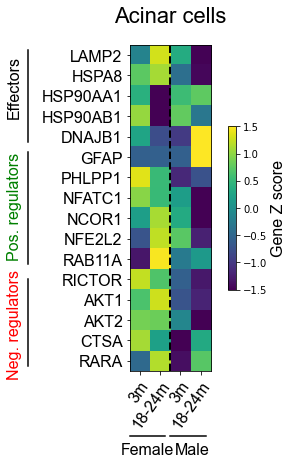

C:\Users\Adrian\AppData\Local\Temp\ipykernel_16428\3121969596.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  female_3m = list(barcode[barcode['cell_type'] == cellpop][barcode['sex'] == "female"][barcode['new_age'] == "3m"].index)
C:\Users\Adrian\AppData\Local\Temp\ipykernel_16428\3121969596.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  female_18_24m = list(barcode[barcode['cell_type'] == cellpop][barcode['sex'] == "female"][barcode['new_age'] == "18-24m"].index)
C:\Users\Adrian\AppData\Local\Temp\ipykernel_16428\3121969596.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  male_3m = list(barcode[barcode['cell_type'] == cellpop][barcode['sex'] == "male"][barcode['new_age'] == "3m"].index)
C:\Users\Adrian\AppData\Local\Temp\ipykernel_16428\3121969596.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  male_18_24m = list(barcode[barcode['cell_type'] 

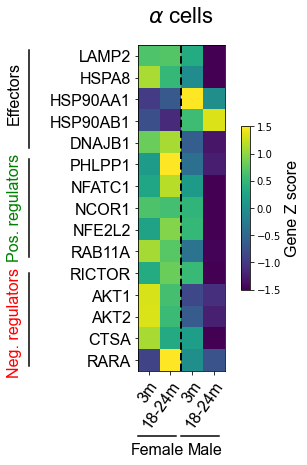

C:\Users\Adrian\AppData\Local\Temp\ipykernel_16428\3121969596.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  female_3m = list(barcode[barcode['cell_type'] == cellpop][barcode['sex'] == "female"][barcode['new_age'] == "3m"].index)
C:\Users\Adrian\AppData\Local\Temp\ipykernel_16428\3121969596.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  female_18_24m = list(barcode[barcode['cell_type'] == cellpop][barcode['sex'] == "female"][barcode['new_age'] == "18-24m"].index)
C:\Users\Adrian\AppData\Local\Temp\ipykernel_16428\3121969596.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  male_3m = list(barcode[barcode['cell_type'] == cellpop][barcode['sex'] == "male"][barcode['new_age'] == "3m"].index)
C:\Users\Adrian\AppData\Local\Temp\ipykernel_16428\3121969596.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  male_18_24m = list(barcode[barcode['cell_type'] 

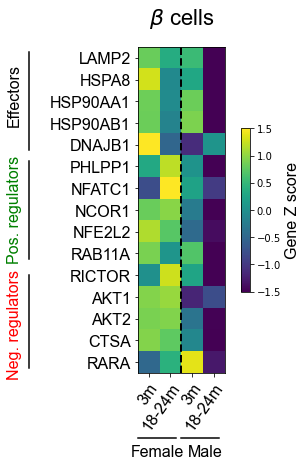

In [53]:
for i in cells:
    sex_heatmaps(cellpop=i)

## Ridge plots for L2 and L1

In [4]:
# Codes for L2 and L1
lys = ['ENSMUSG00000016534', 'ENSMUSG00000031447']

In [5]:
# Selecting only L2 and L1 from adata
adata_lys = adata[:, lys]
barcode_lys = adata.obs.copy()

# Calculating the Z score for L2 & L1
lys_zs = adata_lys.copy().X.todense()

for i in tqdm(np.arange(lys_zs.shape[1])):
    
    µ = np.mean(lys_zs[:, i])
    sd = np.std(lys_zs[:, i])
    
    lys_zs[:, i] = (lys_zs[:, i] - µ)/sd
    
# Converting lys_zs.X to a pandas df
df_lys = pd.DataFrame(lys_zs.tolist())
df_lys.rename(columns={0:"L2", 1:'L1'}, inplace=True)

# Generating barcode df and appending L2 column
barcode_lys = barcode_lys.reset_index()
barcode_lys = pd.concat([barcode_lys, df_lys], axis=1)
barcode_lys = barcode_lys [['index', 'cell', 'cell_type', 'sex', 'age', 'L2', 'L1']]

barcode_lys.head()

100%|██████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 1000.67it/s]


,index,cell,cell_type,sex,age,L2,L1
0,A10_B000756_B007446_S10.mm10-plus-0-0,A10_B000756,type B pancreatic cell,male,18m,0.845789,0.575832
1,A11_B000756_B007446_S11.mm10-plus-0-0,A11_B000756,type B pancreatic cell,male,18m,-1.404442,-2.194588
2,A12_B000756_B007446_S12.mm10-plus-0-0,A12_B000756,type B pancreatic cell,male,18m,0.872438,0.710111
3,A13_B000756_B007446_S13.mm10-plus-0-0,A13_B000756,type B pancreatic cell,male,18m,0.831213,0.638683
4,A13_B002832_B007443_S13.mm10-plus-0-0,A13_B002832,pancreatic acinar cell,female,18m,-1.404442,-2.194588


In [6]:
# Generating new ages
for j in barcode_lys.index:    
    if barcode_lys.loc[j, 'age'] == '3m':        
        barcode_lys.loc[j, 'new_age'] = '3m'

    elif barcode_lys.loc[j, 'age'] == '18m':                
        barcode_lys.loc[j, 'new_age'] = '18-24m'

    elif barcode_lys.loc[j, 'age'] == '24m': 
        barcode_lys.loc[j, 'new_age'] = '18-24m'
        
barcode_lys.head()

,index,cell,cell_type,sex,age,L2,L1,new_age
0,A10_B000756_B007446_S10.mm10-plus-0-0,A10_B000756,type B pancreatic cell,male,18m,0.845789,0.575832,18-24m
1,A11_B000756_B007446_S11.mm10-plus-0-0,A11_B000756,type B pancreatic cell,male,18m,-1.404442,-2.194588,18-24m
2,A12_B000756_B007446_S12.mm10-plus-0-0,A12_B000756,type B pancreatic cell,male,18m,0.872438,0.710111,18-24m
3,A13_B000756_B007446_S13.mm10-plus-0-0,A13_B000756,type B pancreatic cell,male,18m,0.831213,0.638683,18-24m
4,A13_B002832_B007443_S13.mm10-plus-0-0,A13_B002832,pancreatic acinar cell,female,18m,-1.404442,-2.194588,18-24m


In [8]:
# Reducing df only to cells of interest
barcode_lys = barcode_lys[(barcode_lys.cell_type==cells[0]) | (barcode_lys.cell_type==cells[1])|
                         (barcode_lys.cell_type==cells[2])].reset_index(drop=True)

### Graphs

#### Lamp2 female

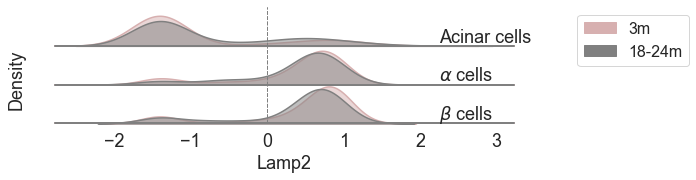

In [16]:
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0), "axes.labelsize":18, "xtick.labelsize":18}, 
              font_scale=2)

g = sns.FacetGrid(barcode_lys[barcode_lys.sex == 'female'], row='cell_type', row_order = cells, hue='new_age', 
                  hue_order= ['3m', '18-24m'], aspect=7, height=1.1, palette=['#D7B0B0', '#808080'])
g.map(sns.kdeplot, 'L2', bw_adjust=1, clip_on=False, fill=True, alpha=0.5, linewidth=1.5)
g.map(plt.axhline, y=0, lw=2, clip_on=False)
g.map(plt.axvline, x=0, lw=1, clip_on=False, color='gray', linestyle='dashed')

g.fig.subplots_adjust(hspace=0)

plt.text(x=2.25, y=2.25, s="Acinar cells", fontsize=18) 
plt.text(x=2.25, y=1.18, s=r"$\alpha$ cells", fontsize=18)
plt.text(x=2.25, y=0.1, s=r"$\beta$ cells", fontsize=18)


# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[], ylabel='')
g.set(xlabel='Lamp2')
g.fig.text(0.04, 0.5, 'Density', va='center', rotation='vertical', fontsize=18)
g.despine(bottom=True, left=True)

# Legend
legend_elements = [Patch(facecolor='#D7B0B0', edgecolor='#D7B0B0', label='3m'),
                   Patch(facecolor='#808080', edgecolor='#808080', label='18-24m')]

plt.legend(handles=legend_elements, bbox_to_anchor = (1.4, 3), facecolor='white', fontsize=16)

plt.savefig('../Khwaja_et_al_outputs/Pancreas/PancL2_ridge_fem.png',bbox_inches='tight', dpi=300)
plt.show()

#### Lamp2 male

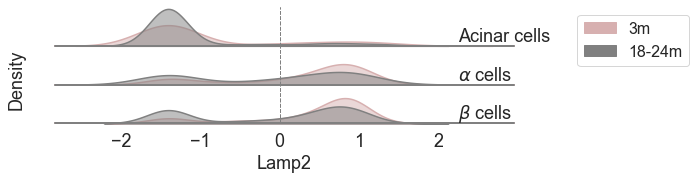

In [28]:
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0), "axes.labelsize":18, "xtick.labelsize":18}, 
              font_scale=2)

g = sns.FacetGrid(barcode_lys[barcode_lys.sex == 'male'], row='cell_type', row_order = cells, hue='new_age', 
                  hue_order= ['3m', '18-24m'], aspect=7, height=1.1, palette=['#D7B0B0', '#808080'])
g.map(sns.kdeplot, 'L2', bw_adjust=1, clip_on=False, fill=True, alpha=0.5, linewidth=1.5)
g.map(plt.axhline, y=0, lw=2, clip_on=False)
g.map(plt.axvline, x=0, lw=1, clip_on=False, color='gray', linestyle='dashed')

g.fig.subplots_adjust(hspace=0)

plt.text(x=2.25, y=3, s="Acinar cells", fontsize=18) 
plt.text(x=2.25, y=1.55, s=r"$\alpha$ cells", fontsize=18)
plt.text(x=2.25, y=0.15, s=r"$\beta$ cells", fontsize=18) 


# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[], ylabel='')
g.set(xlabel='Lamp2')
g.fig.text(0.04, 0.5, 'Density', va='center', rotation='vertical', fontsize=18)
g.despine(bottom=True, left=True)

# Legend
legend_elements = [Patch(facecolor='#D7B0B0', edgecolor='#D7B0B0', label='3m'),
                   Patch(facecolor='#808080', edgecolor='#808080', label='18-24m')]

plt.legend(handles=legend_elements, bbox_to_anchor = (1.4, 3), facecolor='white', fontsize=16)

plt.savefig('../Khwaja_et_al_outputs/Pancreas/PancL2_ridge_male.png',bbox_inches='tight', dpi=300)
plt.show()

#### Lamp1 female

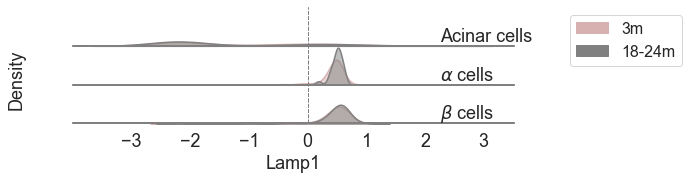

In [46]:
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0), "axes.labelsize":18, "xtick.labelsize":18}, 
              font_scale=2)

g = sns.FacetGrid(barcode_lys[barcode_lys.sex == 'female'], row='cell_type', row_order = cells, hue='new_age', 
                  hue_order= ['3m', '18-24m'], aspect=7, height=1.1, palette=['#D7B0B0', '#808080'])
g.map(sns.kdeplot, 'L1', bw_adjust=1, clip_on=False, fill=True, alpha=0.5, linewidth=1.5)
g.map(plt.axhline, y=0, lw=2, clip_on=False)
g.map(plt.axvline, x=0, lw=1, clip_on=False, color='gray', linestyle='dashed')

g.fig.subplots_adjust(hspace=0)

plt.text(x=2.25, y=9.55, s="Acinar cells", fontsize=18) 
plt.text(x=2.25, y=4.95, s=r"$\alpha$ cells", fontsize=18)
plt.text(x=2.25, y=0.55, s=r"$\beta$ cells", fontsize=18) 


# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[], ylabel='')
g.set(xlabel='Lamp1')
g.fig.text(0.04, 0.5, 'Density', va='center', rotation='vertical', fontsize=18)
g.despine(bottom=True, left=True)

# Legend
legend_elements = [Patch(facecolor='#D7B0B0', edgecolor='#D7B0B0', label='3m'),
                   Patch(facecolor='#808080', edgecolor='#808080', label='18-24m')]

plt.legend(handles=legend_elements, bbox_to_anchor = (1.4, 3), facecolor='white', fontsize=16)

plt.savefig('../Khwaja_et_al_outputs/Pancreas/PancL1_ridge_fem.png',bbox_inches='tight', dpi=300)
plt.show()

#### Lamp1 male

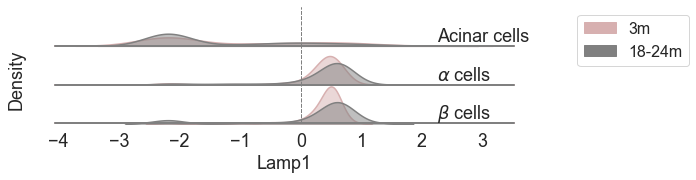

In [57]:
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0), "axes.labelsize":18, "xtick.labelsize":18}, 
              font_scale=2)

g = sns.FacetGrid(barcode_lys[barcode_lys.sex == 'male'], row='cell_type', row_order = cells, hue='new_age', 
                  hue_order= ['3m', '18-24m'], aspect=7, height=1.1, palette=['#D7B0B0', '#808080'])
g.map(sns.kdeplot, 'L1', bw_adjust=1, clip_on=False, fill=True, alpha=0.5, linewidth=1.5)
g.map(plt.axhline, y=0, lw=2, clip_on=False)
g.map(plt.axvline, x=0, lw=1, clip_on=False, color='gray', linestyle='dashed')

g.fig.subplots_adjust(hspace=0)

plt.text(x=2.25, y=4.35, s="Acinar cells", fontsize=18) 
plt.text(x=2.25, y=2.25, s=r"$\alpha$ cells", fontsize=18)
plt.text(x=2.25, y=0.25, s=r"$\beta$ cells", fontsize=18)

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[], ylabel='')
g.set(xlabel='Lamp1')
g.fig.text(0.04, 0.5, 'Density', va='center', rotation='vertical', fontsize=18)
g.despine(bottom=True, left=True)

# Legend
legend_elements = [Patch(facecolor='#D7B0B0', edgecolor='#D7B0B0', label='3m'),
                   Patch(facecolor='#808080', edgecolor='#808080', label='18-24m')]

plt.legend(handles=legend_elements, bbox_to_anchor = (1.4, 3), facecolor='white', fontsize=16)

plt.savefig('../Khwaja_et_al_outputs/Pancreas/PancL1_ridge_male.png',bbox_inches='tight', dpi=300)
plt.show()

## L2 Bar graphs

### Stats

In [58]:
# 2-way Anova for all cells
for i in cells:
    intdf = barcode_lys[barcode_lys['cell_type']==i].reset_index(drop=True)    
    
    # 2-way Anova
    model = ols('L2 ~ C(new_age) + C(sex) + C(new_age):C(sex)',data=intdf).fit()
    result = sm.stats.anova_lm(model, type=2)
    print(i.title()+' 2-way Anova\n')
    print(result)
    print('\n')
    
    # Post hocs multi comparissons Bonferroni
    interaction_groups = intdf.new_age.astype(str) + " & " + intdf.sex.astype(str)
    comp = mc.MultiComparison(intdf['L2'], interaction_groups)
    tbl, a1, a2 = comp.allpairtest(stats.ttest_ind, method= "bonf")
    print(i.title()+' Post-Hoc Bonferroni\n')
    print(tbl)
    print('\n')

Pancreatic Acinar Cell 2-way Anova

                      df      sum_sq   mean_sq         F    PR(>F)
C(new_age)           1.0    1.023473  1.023473  1.406974  0.236052
C(sex)               1.0    5.048558  5.048558  6.940281  0.008656
C(new_age):C(sex)    1.0    5.078207  5.078207  6.981040  0.008463
Residual           572.0  416.089048  0.727428       NaN       NaN


Pancreatic Acinar Cell Post-Hoc Bonferroni

Test Multiple Comparison ttest_ind 
FWER=0.05 method=bonf
alphacSidak=0.01, alphacBonf=0.008
     group1         group2      stat   pval  pval_corr reject
-------------------------------------------------------------
18-24m & female 18-24m & male  3.8987 0.0001    0.0007   True
18-24m & female   3m & female  1.4309 0.1539    0.9234  False
18-24m & female     3m & male  0.8989 0.3697       1.0  False
  18-24m & male   3m & female -1.8019 0.0724    0.4343  False
  18-24m & male     3m & male -2.3592 0.0189    0.1131  False
    3m & female     3m & male -0.4579 0.6476       1.0  

### Graphs

In [59]:
sns.reset_defaults()

#### Acinar cells

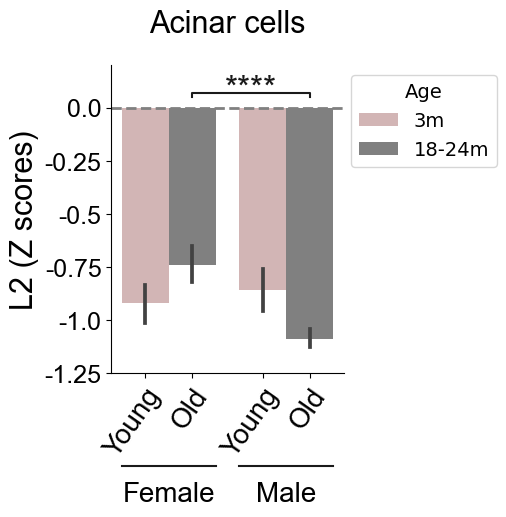

In [70]:
fig, ax = plt.subplots(figsize=(3,4))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
hfont = {'fontname':'Arial'}

sns.barplot(x='sex', y='L2', data=barcode_lys[barcode_lys.cell_type==cells[0]], 
            hue='new_age', order=["female", "male"], hue_order=['3m', "18-24m"], palette=['#D7B0B0', '#808080'], ci=68)

plt.axhline(y=0, linestyle='dashed', linewidth=2, color='gray', zorder=1)
plt.xlabel('')
plt.ylabel('L2 (Z scores)', fontdict={'family':'Arial', 'size': 22})
ax.set_xticks([-0.2, 0.2, 0.8, 1.2])
ax.set_xticklabels(["Young", "Old", "Young", "Old"], fontdict={'family':'Arial', 'size': 20}, 
                   rotation=55, ha='right', rotation_mode='anchor')
plt.ylim(-1.25, 0.20)
ax.set_yticks([-1.25, -1.0, -0.75, -0.5, -0.25, 0.0])
ax.set_yticklabels([-1.25, -1.0, -0.75, -0.5, -0.25, 0.0], fontdict={'family':'Arial', 'size': 18})
h, l = ax.get_legend_handles_labels()
ax.legend(h, ['3m', "18-24m"], bbox_to_anchor=(1.7, 1), title="Age", title_fontsize = "14", fontsize = 14, 
          facecolor='white')
plt.title(label='Acinar cells', fontdict={'family':'Arial', 'size': 22}, y=1.08) 

# statistical annotation
x1, x2 = 0.2, 1.2   
y, h, col = 0.05 , 0.02, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, 0.015, "****", ha='center', va='bottom', color=col, fontdict={'family':'Arial', 'size': 24})

# Female & male
trans = ax.get_xaxis_transform()
ax.annotate('Female', xy=(0, -.35), xycoords=trans, ha="center", va="top", size=20, **hfont)
ax.plot([-.4,0.4],[-.3,-.3], color="k", transform=trans, clip_on=False)
ax.annotate('Male', xy=(1, -.35), xycoords=trans, ha="center", va="top", size=20, **hfont)
ax.plot([0.6,1.4],[-.3,-.3], color="k", transform=trans, clip_on=False)

plt.savefig('../Khwaja_et_al_outputs/Pancreas/Acin_L2_sex.png',bbox_inches='tight', dpi=300)

plt.show()

#### Alpha cells

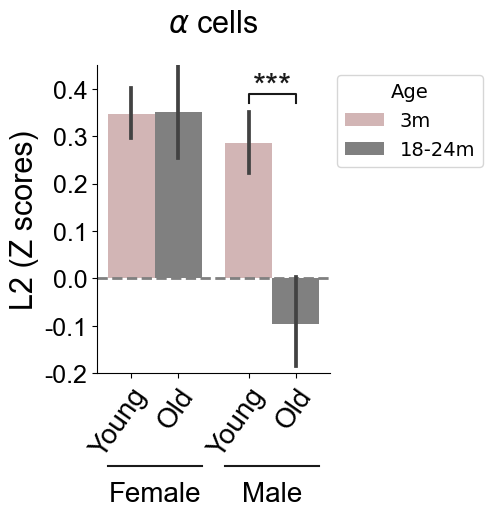

In [77]:
fig, ax = plt.subplots(figsize=(3,4))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
hfont = {'fontname':'Arial'}

sns.barplot(x='sex', y='L2', data=barcode_lys[barcode_lys.cell_type==cells[1]], 
            hue='new_age', order=["female", "male"], hue_order=['3m', "18-24m"], palette=['#D7B0B0', '#808080'], ci=68)

plt.axhline(y=0, linestyle='dashed', linewidth=2, color='gray', zorder=1)
plt.xlabel('')
plt.ylabel('L2 (Z scores)', fontdict={'family':'Arial', 'size': 22})
ax.set_xticks([-0.2, 0.2, 0.8, 1.2])
ax.set_xticklabels(["Young", "Old", "Young", "Old"], fontdict={'family':'Arial', 'size': 20}, 
                   rotation=55, ha='right', rotation_mode='anchor')
plt.ylim(0, 0.45)
ax.set_yticks([-0.20, -0.10, 0.0, 0.10, 0.20, 0.30, 0.40])
ax.set_yticklabels([-0.20, -0.10, 0.0, 0.10, 0.20, 0.30, 0.40], fontdict={'family':'Arial', 'size': 18})
h, l = ax.get_legend_handles_labels()
ax.legend(h, ['3m', "18-24m"], bbox_to_anchor=(1.7, 1), title="Age", title_fontsize = "14", fontsize = 14, 
          facecolor='white')
plt.title(label=r'$\alpha$ cells', fontdict={'family':'Arial', 'size': 22}, y=1.08) 

# statistical annotation
x1, x2 = 0.8, 1.2   
y, h, col = 0.37 , 0.02, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y, "***", ha='center', va='bottom', color=col, fontdict={'family':'Arial', 'size': 24})

# Female & male
trans = ax.get_xaxis_transform()
ax.annotate('Female', xy=(0, -.35), xycoords=trans, ha="center", va="top", size=20, **hfont)
ax.plot([-.4,0.4],[-.3,-.3], color="k", transform=trans, clip_on=False)
ax.annotate('Male', xy=(1, -.35), xycoords=trans, ha="center", va="top", size=20, **hfont)
ax.plot([0.6,1.4],[-.3,-.3], color="k", transform=trans, clip_on=False)

plt.savefig('../Khwaja_et_al_outputs/Pancreas/A_L2_sex.png',bbox_inches='tight', dpi=300)

plt.show()

#### Beta cells

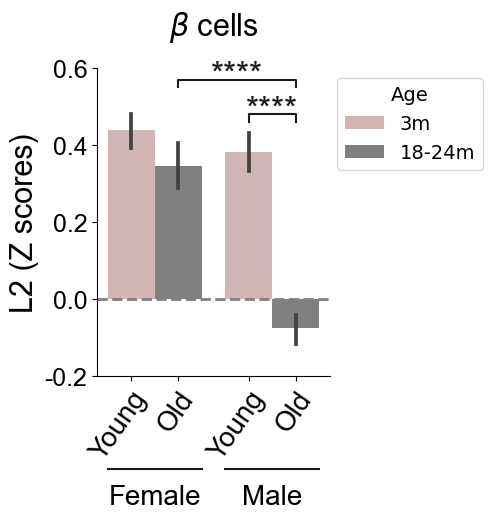

In [87]:
fig, ax = plt.subplots(figsize=(3,4))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
hfont = {'fontname':'Arial'}

sns.barplot(x='sex', y='L2', data=barcode_lys[barcode_lys.cell_type==cells[2]], 
            hue='new_age', order=["female", "male"], hue_order=['3m', "18-24m"], palette=['#D7B0B0', '#808080'], ci=68)

plt.axhline(y=0, linestyle='dashed', linewidth=2, color='gray', zorder=1)
plt.xlabel('')
plt.ylabel('L2 (Z scores)', fontdict={'family':'Arial', 'size': 22})
ax.set_xticks([-0.2, 0.2, 0.8, 1.2])
ax.set_xticklabels(["Young", "Old", "Young", "Old"], fontdict={'family':'Arial', 'size': 20}, 
                   rotation=55, ha='right', rotation_mode='anchor')
plt.ylim(0, 0.6)
ax.set_yticks([-0.20, 0.0, 0.20, 0.40, 0.60])
ax.set_yticklabels([-0.20, 0.0, 0.20, 0.40, 0.60], fontdict={'family':'Arial', 'size': 18})
h, l = ax.get_legend_handles_labels()
ax.legend(h, ['3m', "18-24m"], bbox_to_anchor=(1.7, 1), title="Age", title_fontsize = "14", fontsize = 14, 
          facecolor='white')
plt.title(label=r'$\beta$ cells', fontdict={'family':'Arial', 'size': 22}, y=1.08) 

# statistical annotation
x1, x2 = 0.8, 1.2   
y, h, col = 0.46 , 0.02, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y-0.01, "****", ha='center', va='bottom', color=col, fontdict={'family':'Arial', 'size': 24})

x1, x2 = 0.2, 1.2   
y, h, col = 0.55 , 0.02, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y-0.01, "****", ha='center', va='bottom', color=col, fontdict={'family':'Arial', 'size': 24})


# Female & male
trans = ax.get_xaxis_transform()
ax.annotate('Female', xy=(0, -.35), xycoords=trans, ha="center", va="top", size=20, **hfont)
ax.plot([-.4,0.4],[-.3,-.3], color="k", transform=trans, clip_on=False)
ax.annotate('Male', xy=(1, -.35), xycoords=trans, ha="center", va="top", size=20, **hfont)
ax.plot([0.6,1.4],[-.3,-.3], color="k", transform=trans, clip_on=False)

plt.savefig('../Khwaja_et_al_outputs/Pancreas/B_L2_sex.png',bbox_inches='tight', dpi=300)

plt.show()

### Raw data

In [88]:
# Extracting raw values for bar graphs graphic
def raw (tipos, edad, sex):
    long = []
    celula = []
    age = []
    mean=[]
    sem=[]
    sexo = []

    for i in tipos:
        for x in edad:
            for y in sex:
                n = len(barcode_lys[barcode_lys['cell_type']== i][barcode_lys['new_age']== x][barcode_lys['sex']== y].index)
                m = np.mean(barcode_lys[barcode_lys['cell_type']== i][barcode_lys['new_age']== x][barcode_lys['sex']== y]['L2'])
                s = stats.sem(barcode_lys[barcode_lys['cell_type']== i][barcode_lys['new_age']== x][barcode_lys['sex']== y]['L2'])

                long.append(n)
                celula.append(i)                
                age.append(x)
                sexo.append(y)
                mean.append(m)
                sem.append(s)

    df_raw = pd.DataFrame({"Cell_type": celula, "Age": age, "Sex":sexo, "n": long, "Mean":mean, "SEM": sem})
    with pd.ExcelWriter("../Khwaja_et_al_outputs/Pancreas/Raw_data.xlsx", mode="a", if_sheet_exists='replace',
                        engine="openpyxl") as writer:
        df_raw.to_excel(writer, sheet_name="L2bysex", index=False)
    return(df_raw)

In [89]:
raw(tipos = cells, edad=['3m', '18-24m'], sex=['female', 'male'])

C:\Users\Adrian\AppData\Local\Temp\ipykernel_5360\3841574284.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  n = len(barcode_lys[barcode_lys['cell_type']== i][barcode_lys['new_age']== x][barcode_lys['sex']== y].index)
C:\Users\Adrian\AppData\Local\Temp\ipykernel_5360\3841574284.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  m = np.mean(barcode_lys[barcode_lys['cell_type']== i][barcode_lys['new_age']== x][barcode_lys['sex']== y]['L2'])
C:\Users\Adrian\AppData\Local\Temp\ipykernel_5360\3841574284.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  s = stats.sem(barcode_lys[barcode_lys['cell_type']== i][barcode_lys['new_age']== x][barcode_lys['sex']== y]['L2'])


,Cell_type,Age,Sex,n,Mean,SEM
0,pancreatic acinar cell,3m,female,100,-0.920360,0.091472
1,pancreatic acinar cell,3m,male,91,-0.858274,0.100495
2,pancreatic acinar cell,18-24m,female,118,-0.738579,0.087563
3,pancreatic acinar cell,18-24m,male,267,-1.087153,0.045136
4,pancreatic A cell,3m,female,181,0.347254,0.054330
5,pancreatic A cell,3m,male,183,0.286665,0.061917
6,pancreatic A cell,18-24m,female,41,0.350451,0.101201
7,pancreatic A cell,18-24m,male,116,-0.097045,0.092808
8,type B pancreatic cell,3m,female,281,0.438310,0.044846
9,type B pancreatic cell,3m,male,241,0.383498,0.049972
